In [6]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from gensim.models import Word2Vec

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DistilBertModel
)

from datasets import Dataset

nltk.download('stopwords')
from nltk.corpus import stopwords


print("CUDA available:", torch.cuda.is_available())
print("Using device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

CUDA available: True
Using device: cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Carmine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load dataset
df = pd.read_json("data/Electronics_5.json", lines=True)

df = df.sample(frac=1/6, random_state=42).reset_index(drop=True)

# Filter & map ratings to sentiment
def map_sentiment(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

df['sentiment'] = df['overall'].apply(map_sentiment)
df['reviewText'] = df['reviewText'].astype(str)


In [ ]:
# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text) # rimozione punteggiatura
    text = re.sub(r"\d+", "", text) # rimozione numeri
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])
    return text

df['cleaned'] = df['reviewText'].swifter.apply(clean_text)

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned'], df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=42
)   


In [ ]:
# Show comparison of original and cleaned reviews
comparison_df = df[['reviewText', 'cleaned', 'sentiment']]
print(comparison_df.head(10))  
comparison_df.head(10)         

# Save cleaned reviews to JSON
comparison_df.to_json("data/cleaned_reviews.json", orient="records", lines=True)



In [4]:
# Load cleaned reviews from the saved JSON
df = pd.read_json("data/cleaned_reviews.json", lines=True)

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned'], df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=42
)   


In [4]:
# === Traditional Models ===

# TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(train_texts)
X_test = tfidf.transform(test_texts)


In [5]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, train_labels)
lr_preds = lr.predict(X_test)

In [6]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, train_labels)
nb_preds = nb.predict(X_test)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.64      0.68     25835
     neutral       0.42      0.09      0.15     16820
    positive       0.90      0.98      0.94    181998

    accuracy                           0.87    224653
   macro avg       0.68      0.57      0.59    224653
weighted avg       0.84      0.87      0.85    224653



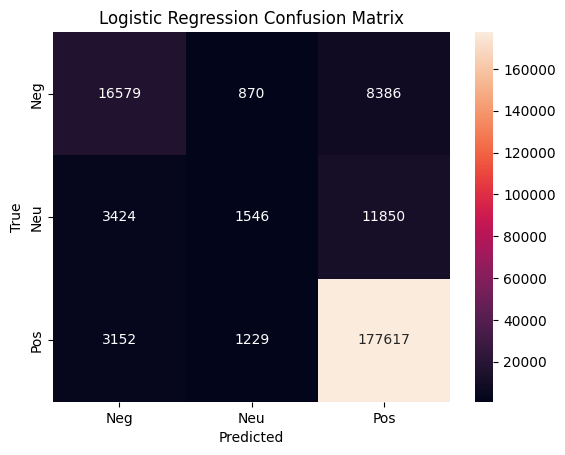


Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.28      0.41     25835
     neutral       0.45      0.00      0.01     16820
    positive       0.84      1.00      0.91    181998

    accuracy                           0.84    224653
   macro avg       0.70      0.43      0.44    224653
weighted avg       0.81      0.84      0.79    224653



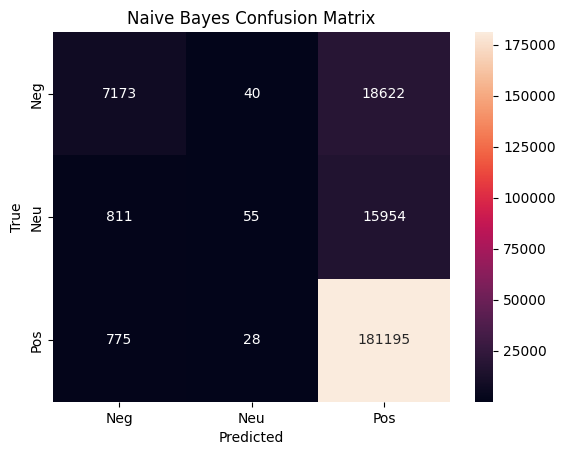

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def evaluate_model(name, preds):
    print(f"\n{name} Classification Report:")
    print(classification_report(test_labels, preds))
    cm = confusion_matrix(test_labels, preds, labels=["negative", "neutral", "positive"])
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["Neg", "Neu", "Pos"], yticklabels=["Neg", "Neu", "Pos"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_model("Logistic Regression", lr_preds)
evaluate_model("Naive Bayes", nb_preds)

# === Transformer-based Model ===

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

In [8]:
# Encode labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['sentiment'].map(label_map)

# Prepare dataset
tokenized_data = tokenizer(list(df['reviewText']), padding=True, truncation=True, return_tensors='pt')
dataset = Dataset.from_dict({
    'input_ids': tokenized_data['input_ids'],
    'attention_mask': tokenized_data['attention_mask'],
    'label': df['label']
})
dataset = dataset.train_test_split(test_size=0.2)

In [9]:
model.to("cuda")

# Define Trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    report_to="none",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    fp16=True,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
)

trainer.train()

# Evaluate BERT model
bert_preds = trainer.predict(dataset['test']).predictions.argmax(-1)
bert_labels = dataset['test']['label']
print("\nDistilBERT Classification Report:")
print(classification_report(bert_labels, bert_preds, target_names=["negative", "neutral", "positive"]))

Epoch,Training Loss,Validation Loss
1,0.242300,0.226859
2,0.199000,0.222923



DistilBERT Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.84      0.83     25983
     neutral       0.53      0.41      0.47     16850
    positive       0.96      0.97      0.97    181820

    accuracy                           0.92    224653
   macro avg       0.77      0.74      0.75    224653
weighted avg       0.91      0.92      0.91    224653



In [1]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Tokenizzazione della colonna 'cleaned'
tokenized_reviews = [review.split() for review in df['cleaned']]
y = df['sentiment']

# Funzione per ottenere la media degli embedding per un documento
def document_vector(doc, model):
    words = doc.split()
    valid_words = [word for word in words if word in model.wv]
    return np.mean(model.wv[valid_words], axis=0) if valid_words else np.zeros(model.vector_size)

# Funzione per addestrare, creare i document embeddings, classificare e valutare
def train_and_evaluate(model_name, sg_value):
    print(f"\n### {model_name} (sg={sg_value}) ###")

    # Addestramento Word2Vec
    w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4, sg=sg_value)

    # Creazione feature matrix
    X_w2v = np.array([document_vector(doc, w2v_model) for doc in df['cleaned']])

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

    # Classificatore
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Stampa classification report
    print(classification_report(y_test, y_pred))

# Esegui entrambi i modelli
train_and_evaluate("CBOW", sg_value=0)
train_and_evaluate("Skip-gram", sg_value=1)


NameError: name 'df' is not defined

Using device: cuda


### Word2Vec + Logistic Regression | sg=0 | BERT=NO ###
              precision    recall  f1-score   support

    negative       0.70      0.50      0.59     25761
     neutral       0.31      0.03      0.06     16929
    positive       0.87      0.98      0.92    181963

    accuracy                           0.85    224653
   macro avg       0.63      0.51      0.52    224653
weighted avg       0.81      0.85      0.82    224653



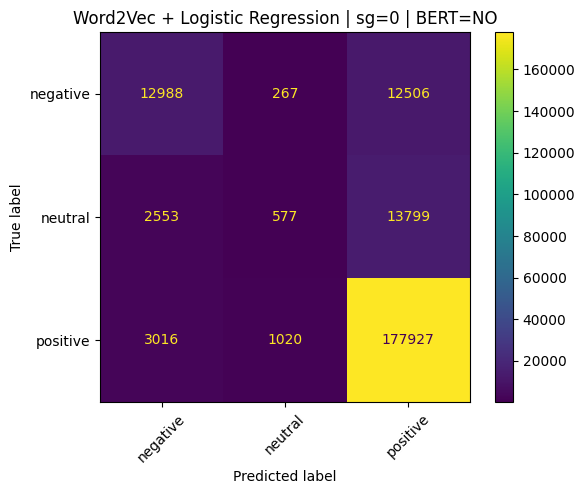



### Word2Vec + Logistic Regression | sg=1 | BERT=NO ###
              precision    recall  f1-score   support

    negative       0.70      0.53      0.60     25761
     neutral       0.33      0.04      0.07     16929
    positive       0.87      0.98      0.92    181963

    accuracy                           0.85    224653
   macro avg       0.63      0.51      0.53    224653
weighted avg       0.81      0.85      0.82    224653



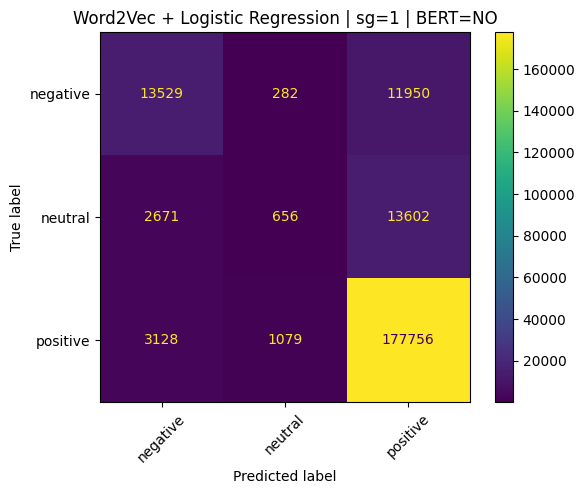



### Word2Vec + DistilBERT | sg=0 | BERT=YES ###
              precision    recall  f1-score   support

    negative       0.72      0.70      0.71     25761
     neutral       0.43      0.11      0.17     16929
    positive       0.91      0.97      0.94    181963

    accuracy                           0.88    224653
   macro avg       0.68      0.59      0.61    224653
weighted avg       0.85      0.88      0.86    224653



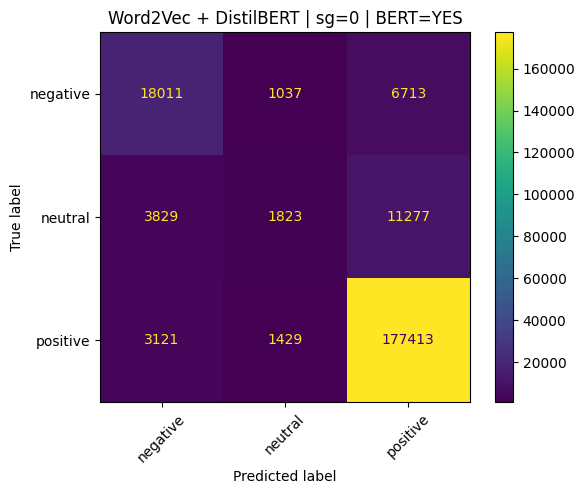



### Word2Vec + DistilBERT | sg=1 | BERT=YES ###
              precision    recall  f1-score   support

    negative       0.72      0.70      0.71     25761
     neutral       0.43      0.11      0.18     16929
    positive       0.91      0.98      0.94    181963

    accuracy                           0.88    224653
   macro avg       0.69      0.60      0.61    224653
weighted avg       0.85      0.88      0.86    224653



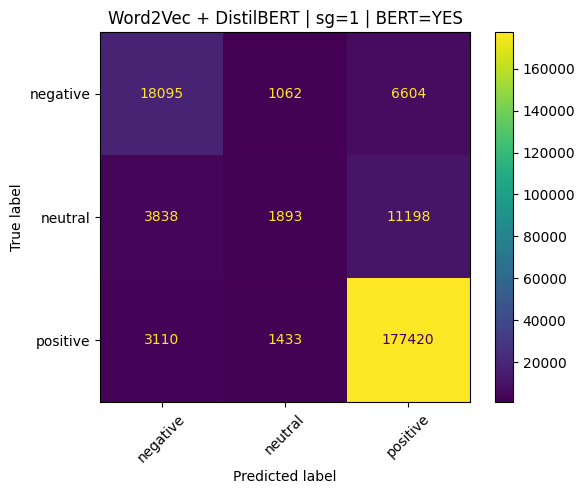

In [ ]:

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)



    # DistilBERT setup
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    bert_model.to(device)

    # Funzione per ottenere embedding DistilBERT (media dei token embeddings)
    def get_bert_embeddings(texts, batch_size=32):
        embeddings = []

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = bert_model(**inputs)

            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(batch_embeddings)

        return np.vstack(embeddings)



    # Funzione per ottenere media embedding Word2Vec per un documento
    def document_vector(doc, model):
        words = doc.split()
        valid_words = [word for word in words if word in model.wv]
        return np.mean(model.wv[valid_words], axis=0) if valid_words else np.zeros(model.vector_size)

    # Funzione principale per il test e confronto
    def run_experiment(model_name, sg_value, use_bert=False):
        print(f"\n\n### {model_name} | sg={sg_value} | BERT={'YES' if use_bert else 'NO'} ###")

        # Tokenizzazione base
        tokenized_reviews = [review.split() for review in df['cleaned']]

        # Addestra modello Word2Vec
        w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4, sg=sg_value)

        # Embedding Word2Vec
        X_w2v = np.array([document_vector(doc, w2v_model) for doc in df['cleaned']])

        # Embedding BERT (opzionale)
        if use_bert:
            X_bert = get_bert_embeddings(df['reviewText'])
            X = np.concatenate([X_w2v, X_bert], axis=1)  # concatena Word2Vec + BERT
        else:
            X = X_w2v

        y = df['sentiment']

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Classificatore
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Report
        print(classification_report(y_test, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot(xticks_rotation=45)
        plt.title(f"{model_name} | sg={sg_value} | BERT={'YES' if use_bert else 'NO'}")
        plt.show()

    # Esegui tutti gli esperimenti
    run_experiment("Word2Vec + Logistic Regression", sg_value=0, use_bert=False)  # CBOW
    run_experiment("Word2Vec + Logistic Regression", sg_value=1, use_bert=False)  # Skip-gram
    run_experiment("Word2Vec + DistilBERT", sg_value=0, use_bert=True)            # CBOW + BERT
    run_experiment("Word2Vec + DistilBERT", sg_value=1, use_bert=True)            # Skip-gram + BERT
